In [115]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
from bayes_opt import BayesianOptimization
from scipy.optimize import root_scalar
from scipy import integrate,special
import pymongo
import copy

In [123]:
#Define the constants
main_detune = 17
sideband_detune = 120
white_detune = 10
laser_on = 200000
laser_off = 400015
MOT_power = 50
v0_start=1
v0_step=1
v0_end=25
t0_start=0
t0_step=1
t0_end=3500000

Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
mag_field_grad = 1252.8168984164048*x0
waist = 0.012/x0
v_max = 8.
z_max = 0.012/x0
z_start = 0.012/x0
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3
t_eval = np.arange(t0_start,t0_end,t0_step)

# The detunings used in the PRAs:
intensities = 2.*MOT_power*1e-3/(np.pi*0.012**2)/Isat

#Define the hamiltonian
H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(N=1,I=0.5,B=15496.8125/Gamma,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,gI=5.585,gS=2.0023193043622,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    muN=cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')*1e-4*1e-6/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(J=0.5,I=0.5,
    P=+1,B=15788.2/Gamma,D=0.,H=0.,a=109./Gamma,b=-299.2/Gamma,c=274.2/Gamma,q=0., p=15./Gamma,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    muN=cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')*1e-4*1e-6/Gamma,return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [124]:
def Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    pX = (p1+p2+p3+p4)/4
    pp1 = p1 - pX
    pp2 = p2 - pX
    pp3 = p3- pX
    pp4 = p4 - pX
    
    def intensity_res(pp):
        intensity_norm = 0.050
        result = 2.*(intensity_norm+pp/(10**3))/(np.pi*(0.012)**2)/Isat
        return result
    
    def sigmoid_function(x):
        if (1/(1+np.exp(-1*x))*2)//1 == 1.:
            return +1
        else:
            return -11
    
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        if ii<1:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp1), delta=(E_A[-1] - Eg_i)+d1,pol=sigmoid_function(pol1),wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        elif ii==1:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp2), delta=(E_A[-1] - Eg_i)+d2,pol=sigmoid_function(pol2),wb=waist,
                beam_type=pylcp.gaussianBeam)
        elif ii==2:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp3), delta=(E_A[-1] - Eg_i)+d3,pol=sigmoid_function(pol3),wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        else:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp4), delta=(E_A[-1] - Eg_i)+d4,pol=sigmoid_function(pol4),wb=waist,
                beam_type=pylcp.gaussianBeam
                )

    return laserBeams

In [125]:
def vc_bayesian(v0s,Bgrad, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    def trap_condition(t,y):
        if abs(y[-3])*1000*x0<6 and abs(y[-6])<5e-2 and abs(y[-2])*1000*x0<6 and abs(y[-5])<5e-2 and abs(y[1])*x0*1000<6 and abs(y[-4])<5e-2:
            val = -1.
        else:
            val = 1.
        return val
    
    def lost_condition(t,y):
        if y[-3]*1000*x0>13 or y[-2]*1000*x0>13:
            val = -1.
        else:
            val=1.
        return val
    trap_condition.terminal = True
    lost_condition.terminal = True
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField = pylcp.quadrupoleMagneticField(Bgrad*x0*1000)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)

    eqn.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,0]),np.array([v0s,v0s,0]))
    eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

    eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= [trap_condition,lost_condition],progress_bar = 0,method='LSODA',max_step=2e5)
    sol = eqn.sol
    
    if len(sol.t_events[0])==1:
        return v0s
    else:
        return -1.

In [126]:
def vc_func(v0s,Bgrad, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    def trap_condition(t,y):
        if abs(y[-3])*1000*x0<6 and abs(y[-6])<5e-2 and abs(y[-2])*1000*x0<6 and abs(y[-5])<5e-2 and abs(y[1])*x0*1000<6 and abs(y[-4])<5e-2:
            val = -1.
        else:
            val = 1.
        return val
    
    def lost_condition(t,y):
        if y[-3]*1000*x0>13 or y[-2]*1000*x0>13:
            val = -1.
        else:
            val=1.
        return val
    trap_condition.terminal = True
    lost_condition.terminal = True
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField = pylcp.quadrupoleMagneticField(Bgrad*x0*1000)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)

    eqn.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,0]),np.array([v0s,v0s,0]))
    eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

    eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= [trap_condition,lost_condition],progress_bar = 0,method='LSODA',max_step=2e5)
    
    return eqn.sol

In [127]:
start = time.time()

result = vc_func(**max_parameters[0]["params"])

print(time.time()-start)

14.445363521575928


In [128]:
result.v[0][-1]

-0.04999781600843922

In [23]:
pbounds = {'v0s':(2,8),'Bgrad':(0.5,2),'d1':(-3,1),'d2':(-3,1),'d3':(-3,1),'d4':(-3,1),'p1':(0,50),'p2':(0,50),'p3':(0,50),'p4':(0,50),'pol1':(-1,1),'pol2':(-1,1),'pol3':(-1,1),'pol4':(-1,1)}

In [24]:
optimizer = BayesianOptimization(
    f = vc_bayesian,
    pbounds=pbounds,
    verbose=13,
    random_state=1,
)

In [25]:
start = time.time()
optimizer.maximize(
    init_points=1,
    n_iter=1,)
print(time.time()-start)

|   iter    |  target   |   Bgrad   |    d1     |    d2     |    d3     |    d4     |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    v0s    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -1.0      |  1.126    | -0.1187   | -3.0      | -1.791    | -2.413    |  4.617    |  9.313    |  17.28    |  19.84    |  0.07763  | -0.1616   |  0.3704   | -0.5911   |  7.269    |
|  2        | -1.0      |  1.089    | -0.5539   | -0.8439   | -2.181    | -2.332    |  24.15    |  28.56    |  2.302    |  30.67    | -0.5294   | -0.2846   |  0.7505   |  0.5304   |  2.657    |
17.523131847381592


In [ ]:
from bayes_opt.util import load_logs

# New optimizer is loaded with previously seen points
load_logs(optimizer, logs=["./logs_0428.json"])

In [ ]:
len(optimizer.res)

In [ ]:
optimizer.max

In [26]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path='./logs_0516.json')
optimizer.subscribe(Events.OPTIMIZATION_STEP,logger)

In [33]:
start = time.time()
optimizer.maximize(
    init_points=100,
    n_iter=2000,)
print(time.time()-start)

|   iter    |  target   |   Bgrad   |    d1     |    d2     |    d3     |    d4     |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    v0s    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  3335     | -1.0      |  1.363    | -1.093    |  0.9191   | -2.717    |  0.4697   |  28.93    |  43.82    |  2.786    |  4.958    |  0.7262   |  0.1408   |  0.117    | -0.974    |  5.854    |
|  3336     | -1.0      |  1.771    |  0.9845   | -1.268    | -1.754    | -1.381    |  11.4     |  11.3     |  21.68    |  34.23    |  0.3215   |  0.545    | -0.5664   |  0.4574   |  6.772    |
|  3337     | -1.0      |  1.343    | -1.137    | -2.367    | -2.814    | -1.145    |  32.72    |  10.63    |  20.0     |  24.88    |  0.9098   |  0.7549   |  0.7481   |  0.9932   |  6.641    |
|  3338     | -1.0      |  0.8

In [31]:
start = time.time()
optimizer.maximize(    
    init_points=100,    
    n_iter=1000,)
print(time.time()-start)

|   iter    |  target   |   Bgrad   |    d1     |    d2     |    d3     |    d4     |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    v0s    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  2235     | -1.0      |  1.363    | -1.769    | -2.394    |  0.8851   | -2.34     |  36.36    |  44.54    |  42.94    |  9.213    | -0.5264   | -0.9633   |  0.8628   |  0.7742   |  5.573    |
|  2236     | -1.0      |  0.6641   | -2.306    | -0.6922   | -1.993    | -1.799    |  8.549    |  9.48     |  23.17    |  25.49    |  0.02316  |  0.9943   | -0.7408   |  0.5123   |  6.763    |
|  2237     | -1.0      |  1.377    | -1.149    |  0.5737   |  0.3127   | -2.799    |  48.15    |  0.367    |  28.66    |  28.62    |  0.6688   | -0.2306   | -0.8179   |  0.1634   |  2.149    |
|  2238     | -1.0      |  1.0

In [29]:
import pprint

In [42]:
pprint.pprint(optimizer.max)

{'params': {'Bgrad': 2.0,
            'd1': -2.3470898400453235,
            'd2': -0.17685147868728454,
            'd3': -0.46279508585937834,
            'd4': -1.1236489411936335,
            'p1': 9.712088940682204,
            'p2': 27.03059194113272,
            'p3': 41.9646498356634,
            'p4': 28.02297026580245,
            'pol1': -0.7429073210173194,
            'pol2': 1.0,
            'pol3': 0.1841613319651636,
            'pol4': -0.7475508731194674,
            'v0s': 6.592071166525328},
 'target': 6.592071166525328}


In [ ]:
start = time.time()

optimizer.maximize(init_points=200, n_iter=2000)

print(time.time()-start)

In [35]:
optimizer.max

{'target': 6.592071166525328,
 'params': {'Bgrad': 2.0,
  'd1': -2.3470898400453235,
  'd2': -0.17685147868728454,
  'd3': -0.46279508585937834,
  'd4': -1.1236489411936335,
  'p1': 9.712088940682204,
  'p2': 27.03059194113272,
  'p3': 41.9646498356634,
  'p4': 28.02297026580245,
  'pol1': -0.7429073210173194,
  'pol2': 1.0,
  'pol3': 0.1841613319651636,
  'pol4': -0.7475508731194674,
  'v0s': 6.592071166525328}}

In [36]:
def ploting_function(v0s,Bgrad, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField = pylcp.quadrupoleMagneticField(Bgrad*x0*1000)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    eqn.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)

    eqn.set_initial_position_and_velocity(np.array([-1*z_start,0,0]),np.array([v0s,0,0]))
    eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

    eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= None,progress_bar = 0,method='LSODA')
    
    fig,ax = plt.subplots(1,1,figsize=(13,7))
    
    imz = ax.imshow(eqn.profile['Fx'].F[0]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbz = plt.colorbar(imz,ax = ax)
    cbz.set_label('$a (\mathrm{km/s^2})$')
    ax.set_xlabel('$x (\mathrm{mm})$')
    ax.set_ylabel('$v (\mathrm{m/s})$')
    ax.set_title('X axis force image')
    ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax.set_ylim(-1*v_max*v0,1*v_max*v0)
    fig.subplots_adjust(left=0.12,right=0.9)
    
    
    print(eqn.sol.v[0][-1], eqn.sol.r[0][-1])
    ax.plot(eqn.sol.r[0]*x0*1000,eqn.sol.v[0]*v0,'k') 
#     ax.plot(eqn.sol.r[0]*x0*1000,v0*v0s*np.ones(len(eqn.sol.r[0])),'g')
    # fig.savefig('./MOT/optimized')
    

In [138]:
def ploting_function_2(v0s,Bgrad, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    v_list = np.linspace(v0s-2,v0s+2,11)
    zz = np.linspace(-1*z_max,z_max,100)
    vv = np.linspace(-1*v_max,v_max,100)
    Z,V = np.meshgrid(zz,vv)
    sols_list = list()
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField=pylcp.quadrupoleMagneticField(Bgrad*x0*1000)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    eqn.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)
    eqn.generate_force_profile([np.zeros(Z.shape),Z,np.zeros(Z.shape)],[np.zeros(V.shape),V,np.zeros(V.shape)],name='Fy',progress_bar=1)
    eqn.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='Fz',progress_bar=1)

    def trap_condition(t,y):
        if abs(y[-3])*1000*x0<2 and abs(y[-6])<5e-2 and abs(y[-2])*1000*x0<2 and abs(y[-5])<5e-2:
            val = -1.
        else:
            val = 1.
        return val
    
    def lost_condition(t,y):
        if y[-3]*1000*x0>30 or y[-2]*1000*x0>30:
            val = -1.
        else:
            val=1.
        return val
    
    trap_condition.terminal = True
    lost_condition.terminal = True
    
    for v0ss in v_list:
        eqn.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,0.]),np.array([v0ss,v0ss,0]))
        eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

        eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= [trap_condition,lost_condition],progress_bar = 1,method='LSODA',max_step = 2e5)
        sols_list.append(eqn.sol)
    
    fig,ax = plt.subplots(1,3,figsize=(20,4))
    
    imx = ax[0].imshow(eqn.profile['Fx'].F[0]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbx = plt.colorbar(imx,ax = ax[0])
    cbx.set_label('$a (\mathrm{km/s^2})$')
    
    imy = ax[1].imshow(eqn.profile['Fy'].F[1]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cby = plt.colorbar(imy,ax = ax[1])
    cby.set_label('$a (\mathrm{km/s^2})$')

    imz = ax[2].imshow(eqn.profile['Fz'].F[2]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbz = plt.colorbar(imz,ax = ax[2])
    cbz.set_label('$a (\mathrm{km/s^2})$')

    ax[2].set_xlabel('$z (\mathrm{mm})$')
    ax[2].set_ylabel('$v (\mathrm{m/s})$')
    ax[2].set_title('Z axis force image')
    ax[2].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[2].set_ylim(-1*v_max*v0,1*v_max*v0)

    ax[0].set_xlabel('$x (\mathrm{mm})$')
    ax[0].set_ylabel('$v (\mathrm{m/s})$')
    ax[0].set_title('X axis force image')
    ax[0].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[0].set_ylim(-1*v_max*v0,1*v_max*v0)
    
    ax[1].set_xlabel('$y (\mathrm{mm})$')
    ax[1].set_ylabel('$v (\mathrm{m/s})$')
    ax[1].set_title('Y axis force image')
    ax[1].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[1].set_ylim(-1*v_max*v0,1*v_max*v0)
    fig.subplots_adjust(left=0.12,right=0.9)
    
    print(eqn.sol.v[0][-1], eqn.sol.r[0][-1])
    for sol in sols_list:
        ax[0].plot(sol.r[0]*x0*1000,sol.v[0]*v0)
        ax[1].plot(sol.r[1]*x0*1000,sol.v[1]*v0)
        ax[2].plot(sol.r[2]*x0*1000,sol.v[2]*v0)
        print(sol.v[0][0]*v0, sol.v[1][0]*v0)
#     ax.plot(eqn.sol.r[0]*x0*1000,v0*v0s*np.ones(len(eqn.sol.r[0])),'g')
    fig.savefig('D:/migration/picture/0520/bayes.png')
    

Completed in 13.29 s.                                               
Completed in 13.19 s.                                               
Completed in 13.24 s.                                               
Completed in 6.02 s.                                                  
Completed in 7.06 s.                                                  
Completed in 7.29 s.                                                  
Completed in 7.17 s.                                                  
Completed in 9.31 s.                                                  
Completed in 14.64 s.                                                 
Completed in 12.76 s.                                                 
Completed in 11.55 s.                                                 
Completed in 10.78 s.                                                 
Completed in 10.28 s.                                                 
Completed in 12.87 s.                                                 
8.1413063548

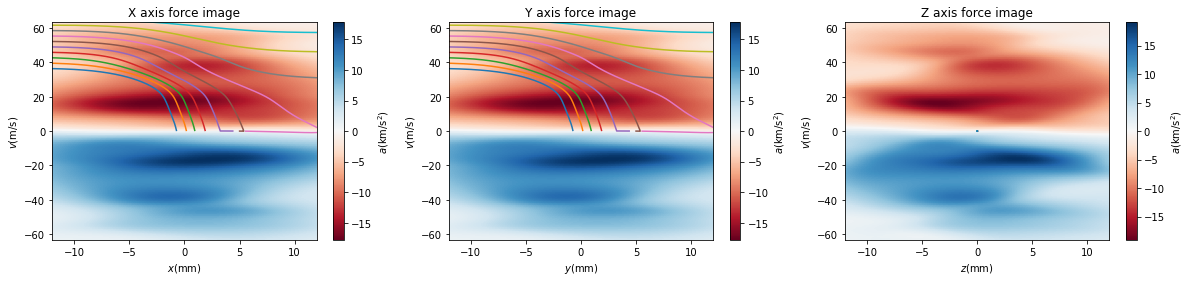

In [139]:
ploting_function_2(**optimizer.max['params'])

In [140]:
def change_pol(sample,pol1,pol2,pol3,pol4):
    target = sample.copy()
    target["pol1"] = pol1
    target["pol2"] = pol2
    target["pol3"] = pol3
    target["pol4"] = pol4
    return target


In [141]:
max_parameters[0]["params"]

{'Bgrad': 1.845384992655863,
 'd1': -2.6166521404797223,
 'd2': 0.4415499192464436,
 'd3': -0.317208870102478,
 'd4': -1.4836887102019047,
 'p1': 10.423033042902253,
 'p2': 26.749243343313022,
 'p3': 41.498620621251256,
 'p4': 27.84887229926405,
 'pol1': -0.9972017796092454,
 'pol2': 0.7788982990462494,
 'pol3': 0.11859774804967471,
 'pol4': -0.9686408510252349,
 'v0s': 6.416576348654973}

Completed in 15.03 s.                                               
Completed in 14.21 s.                                               
Completed in 13.88 s.                                               
Completed in 14.27 s.                                                 
Completed in 12.02 s.                                                 
Completed in 13.85 s.                                                 
Completed in 12.97 s.                                                 
Completed in 13.21 s.                                                 
Completed in 12.10 s.                                                 
Completed in 11.88 s.                                                 
Completed in 12.00 s.                                                 
Completed in 12.82 s.                                                 
Completed in 12.77 s.                                                 
Completed in 12.21 s.                                                 
7.4717661553

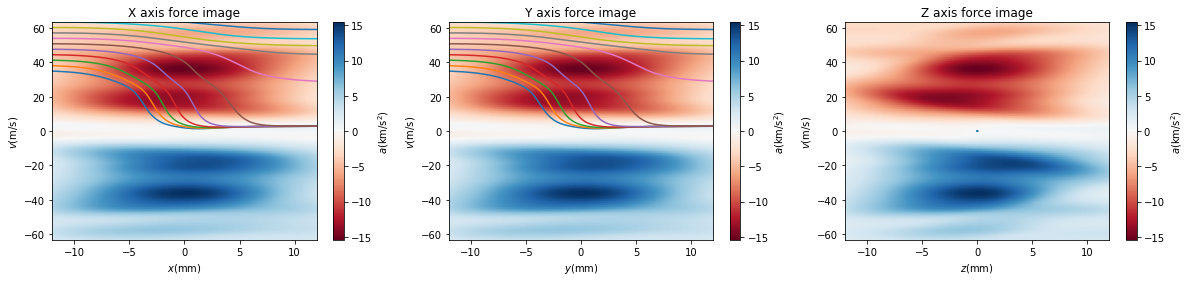

In [147]:
connection = pymongo.MongoClient("localhost:27017")
vc = connection.db.Capture_velocity
max_parameters = vc.find({"target":{"$gte":6.3}},limit=5,projection={"_id":0}).sort("taregt",pymongo.DESCENDING)

target = change_pol(max_parameters[0]["params"],+1,+1,-1,-1)

ploting_function_2(**target)

In [41]:
def ploting_function_3(v0s,Bgrad, d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    # v_list = np.linspace(v0s-2,v0s+2,11)
    zz = np.linspace(-1*z_max,z_max,100)
    vv = np.linspace(-1*v_max,v_max,100)
    Z,V = np.meshgrid(zz,vv)
    sols_list = list()
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField=pylcp.quadrupoleMagneticField(Bgrad*x0*1000)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    eqn.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)
    eqn.generate_force_profile([np.zeros(Z.shape),Z,np.zeros(Z.shape)],[np.zeros(V.shape),V,np.zeros(V.shape)],name='Fy',progress_bar=1)
    eqn.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='Fz',progress_bar=1)


    fig,ax = plt.subplots(1,3,figsize=(20,4))
    imx = ax[0].imshow(eqn.profile['Fx'].F[0]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbx = plt.colorbar(imx,ax = ax[0])
    cbx.set_label('$a (\mathrm{km/s^2})$')
    
    imy = ax[1].imshow(eqn.profile['Fy'].F[1]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cby = plt.colorbar(imy,ax = ax[1])
    cby.set_label('$a (\mathrm{km/s^2})$')

    imz = ax[2].imshow(eqn.profile['Fz'].F[2]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbz = plt.colorbar(imz,ax = ax[2])
    cbz.set_label('$a (\mathrm{km/s^2})$')

Completed in 12.59 s.                                               
Completed in 12.60 s.                                               
Completed in 12.57 s.                                               


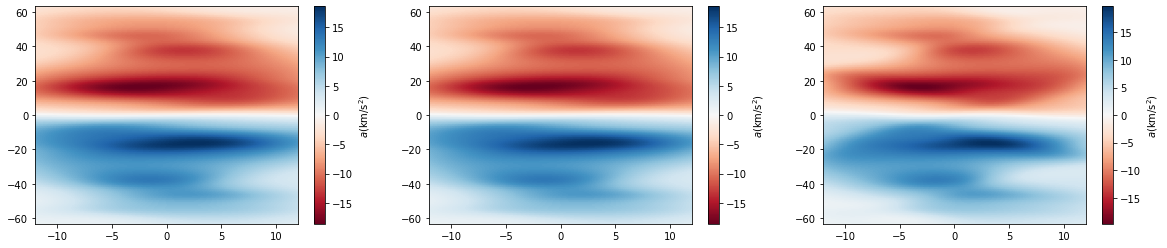

In [40]:
ploting_function_3(**optimizer.max['params'])